4 - 8 Hz 

8- 13 Hz

8 - 25 Hz

look at what has been done with eeg-interpretable learning

feature visualization


In [1]:
from EEGModels import EEGNet
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import os
import scipy
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [30]:
%run "trimmer.ipynb"
%run "training.ipynb"

In [3]:
def bandpass_filter(signal, fs, low_freq, high_freq, order=5):
    # Calculate the normalized cutoff frequencies
    nyquist_freq = 0.5 * fs
    low = low_freq / nyquist_freq
    high = high_freq / nyquist_freq

    # Apply the bandpass filter to each channel separately
    filtered_signal = np.zeros_like(signal)
    for i in range(signal.shape[1]):
        channel_signal = signal[:, i, :]
        b, a = butter(order, [low, high], btype='band')
        filtered_channel = filtfilt(b, a, channel_signal, axis=1)
        filtered_signal[:, i, :] = filtered_channel

    return filtered_signal

# DATA PREPROCESSING AND FILTERING

In [5]:
folder_path = '../../non_condition/non_condition_data/dance_instr_clean_data/'
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]

file_list.sort()

print(file_list)

['../../non_condition/non_condition_data/dance_instr_clean_data/P_1.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/P_10.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/P_2.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/P_3.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/P_4.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/P_5.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/P_9.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/S_1.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/S_10.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/S_2.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/S_3.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/S_4.mat', '../../non_condition/non_condition_data/dance_instr_clean_data/S_5.mat', '../../non_condition/non_condition_data/dance_in

In [6]:
discontinuous_files, total_found = get_discontinuous_files(file_list)

(48, 14, 750)
(31, 14, 750)
(49, 14, 750)
(47, 14, 750)
(66, 14, 750)
(48, 14, 750)
(49, 14, 750)
(66, 14, 750)
(36, 14, 750)
(42, 14, 750)
(72, 14, 750)
(47, 14, 750)
(46, 14, 750)
(57, 14, 750)


In [7]:
print(discontinuous_files)
print(total_found)

[]
0


In [11]:
# X, Y = trim_discontinuous_files(file_list, discontinuous_files, total_found)
X = []
Y = []

for file in file_list:
    x = scipy.io.loadmat(file)
    x = x['data']
    
    # removethe last 250 elements from each trial
    x = x[:,:,:500]

    first_letter = file.split('/')[-1][0]

    # create output vector. If file begins with 'P', then y = [1,0], else y = [0,1], having the same dimension as x
    if first_letter == 'P':
        y = np.zeros((x.shape[0],2))
        y[:,0] = 1
    else:
        y = np.zeros((x.shape[0],2))
        y[:,1] = 1

    X.append(x)
    Y.append(y)


In [12]:
def plot_signals(eeg_array):
    num_samples = eeg_array.shape[0]
    num_channels = eeg_array.shape[1]

    for sample in range(num_samples):
        plt.figure()
        plt.title(f"Sample {sample}")
        for channel in range(num_channels):
            plt.plot(eeg_array[sample, channel, :], label=f"Channel {channel}")
        # plt.legend()
        plt.show()

In [28]:
kick_out = [(7, [36, 50, 54]), (10, [50])]

file_dict = {0: 'P_1', 1: 'P_10', 2: 'P_2', 3: 'P_3', 4: 'P_4', 5: 'P_5', 6: 'P_9', 7: 'S_1', 8: 'S_10', 
             9: 'S_2', 10: 'S_3', 11: 'S_4', 12: 'S_5', 13: 'S_9'}

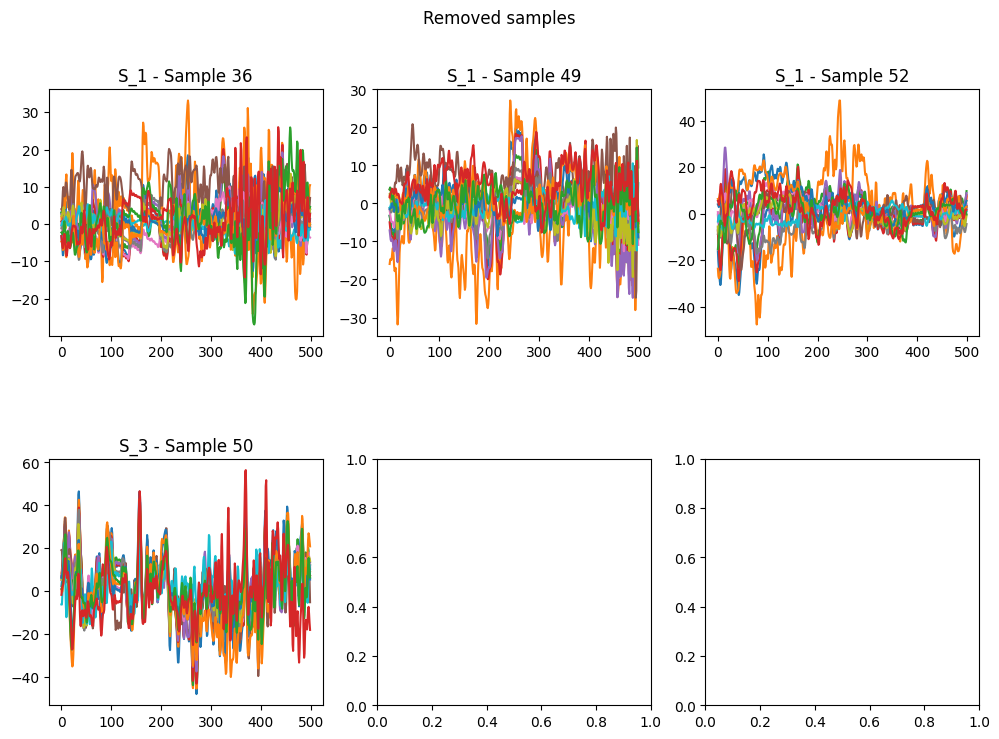

In [31]:
new_X, new_Y = trim_manually(kick_out, X, Y, file_dict)  

In [32]:
print_eliminations(file_list, new_X, new_Y)

(48, 14, 750) -> (48, 14, 500) (48, 2)
(31, 14, 750) -> (31, 14, 500) (31, 2)
(49, 14, 750) -> (49, 14, 500) (49, 2)
(47, 14, 750) -> (47, 14, 500) (47, 2)
(66, 14, 750) -> (66, 14, 500) (66, 2)
(48, 14, 750) -> (48, 14, 500) (48, 2)
(49, 14, 750) -> (49, 14, 500) (49, 2)
(66, 14, 750) -> (63, 14, 500) (63, 2)
(36, 14, 750) -> (36, 14, 500) (36, 2)
(42, 14, 750) -> (42, 14, 500) (42, 2)
(72, 14, 750) -> (71, 14, 500) (71, 2)
(47, 14, 750) -> (47, 14, 500) (47, 2)
(46, 14, 750) -> (46, 14, 500) (46, 2)
(57, 14, 750) -> (57, 14, 500) (57, 2)
Total samples removed:  4
Total samples remaining:  700


# BANDPASS FILTERING

In [33]:
fs = 250

In [34]:
filtered_data_4_8 = []
filtered_data_8_13 = []
filtered_data_8_25 = []
for x in new_X:
    filtered_x_4_8 = bandpass_filter(x, fs, 4, 8)
    filtered_x_8_13 = bandpass_filter(x, fs, 8, 13)
    filtered_x_8_25 = bandpass_filter(x, fs, 8, 25)
    filtered_data_4_8.append(filtered_x_4_8)
    filtered_data_8_13.append(filtered_x_8_13)
    filtered_data_8_25.append(filtered_x_8_25)

Print before and after visualisation of a random eeg signal

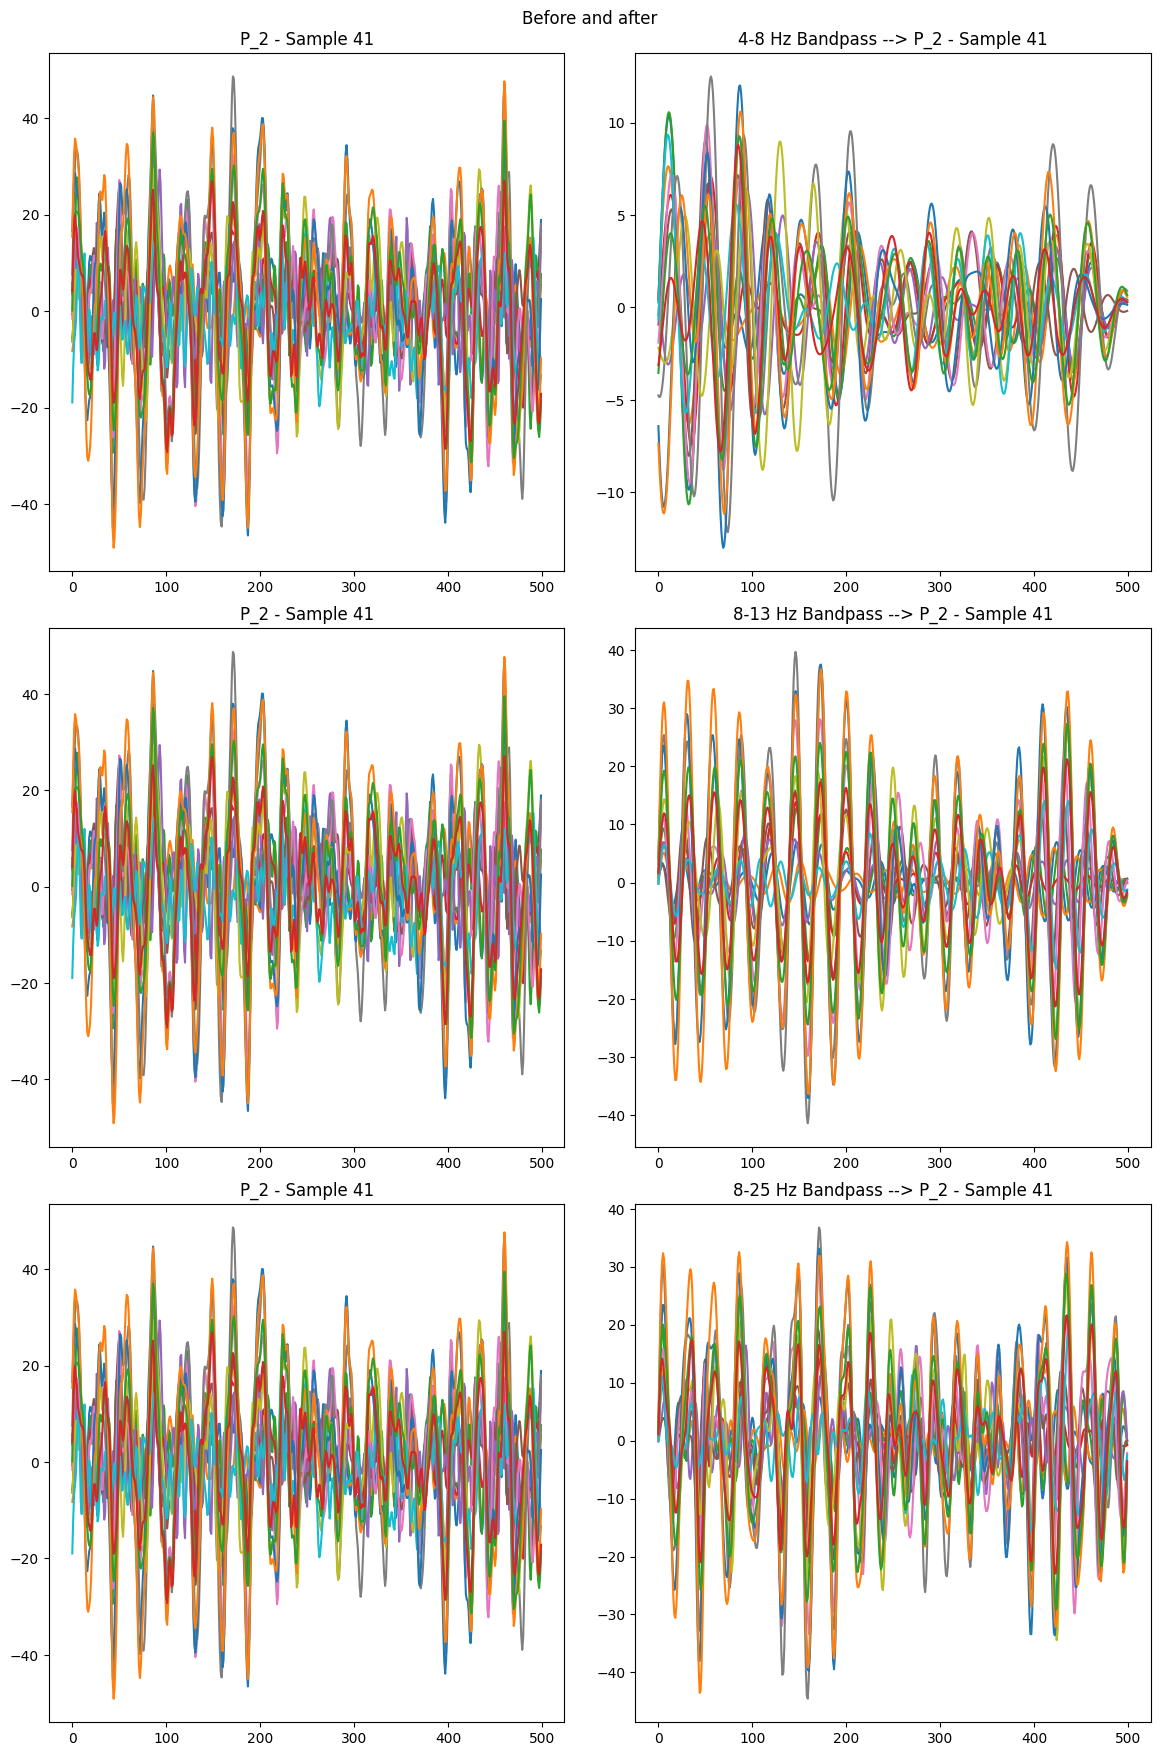

In [35]:
file_index = np.random.randint(0, 13)
sample_index = np.random.randint(0, new_X[file_index].shape[0])

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.suptitle('Before and after')
fig.tight_layout(pad=2.0)

plot_sample(new_X[file_index], sample_index, axes[0, 0], file_dict[file_index])
plot_sample(filtered_data_4_8[file_index], sample_index, axes[0, 1], "4-8 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[1, 0], file_dict[file_index])
plot_sample(filtered_data_8_13[file_index], sample_index, axes[1, 1], "8-13 Hz Bandpass --> " + file_dict[file_index])
plot_sample(new_X[file_index], sample_index, axes[2, 0], file_dict[file_index])
plot_sample(filtered_data_8_25[file_index], sample_index, axes[2, 1], "8-25 Hz Bandpass --> " + file_dict[file_index])

# TRAINING ON THE FILTERED DATA

In [51]:
scroll_style = """
<style>
.output {
    overflow-y: scroll;
    max-height: 300px; /* Adjust the height as per your preference */
}
</style>
"""

In [15]:
kernels, chans, samples = 1, 14, 500

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_4_8, new_Y, "../results/dance_instr_clean/4_8_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/dance_instr_clean/4_8_Hz.txt")

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_8_13, new_Y, "../results/dance_instr_clean/8_13_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/dance_instr_clean/8_13_Hz.txt")

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, filtered_data_8_25, new_Y, "../results/dance_instr_clean/8_25_Hz.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/dance_instr_clean/8_25_Hz.txt")